# Agent-baseret simulation af et simpelt marked

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import urllib.request

# Hent parametre som .csv-filer
urllib.request.urlretrieve("https://raw.githubusercontent.com/DatalogiForAlle/market_competition/master/p_params.csv",
                           "p_params.csv")
urllib.request.urlretrieve("https://raw.githubusercontent.com/DatalogiForAlle/market_competition/master/pe_params.csv",
                          "pe_params.csv")
urllib.request.urlretrieve("https://raw.githubusercontent.com/DatalogiForAlle/market_competition/master/q_params.csv",
                          "q_params.csv")

# Indlæs .csv filer
pe_params = pd.read_csv('pe_params.csv')
p_params = pd.read_csv('p_params.csv')
q_params = pd.read_csv('q_params.csv')

# Udvælg parametre fra det første eksperiment
group_id = 1
pe_params = pe_params[pe_params["Group"] == group_id]
p_params = p_params[p_params["Group"] == group_id]
q_params = q_params[q_params["Group"] == group_id]
pe_params.reset_index()
p_params.reset_index()
q_params.reset_index()

,index,Group,Subject,c,gamma_1,gamma_2,gamma_3,gamma_4,R2,AC_t1,AC_t2,W,Method
0,0,1,1,18.848,0.000,-1.064,0.000,-0.744,0.642,0.293,0.354,0.026,OLS
1,1,1,2,24.141,0.000,-1.488,0.000,-0.591,0.878,0.000,0.000,0.160,OLS
2,2,1,3,13.666,0.000,-3.993,3.463,0.000,0.869,0.137,0.331,0.382,OLS
3,3,1,4,2.140,0.605,-0.987,1.064,-0.664,0.573,0.233,0.163,0.188,OLS
4,4,1,5,2.683,0.432,-3.620,3.733,0.000,0.853,0.125,0.146,0.068,IV
5,5,1,6,10.044,0.000,0.000,0.000,0.000,0.754,0.688,0.836,0.832,OLS
6,6,1,7,9.160,0.482,-0.488,0.000,-0.657,0.393,0.144,0.276,0.000,IV
7,7,1,8,8.912,0.000,-0.955,0.656,0.000,0.747,0.016,0.068,0.636,OLS
8,8,1,9,10.167,0.000,0.000,0.000,0.000,0.700,0.437,0.113,0.708,OLS
9,9,1,10,3.869,0.887,-0.265,0.000,-0.533,0.887,0.335,0.625,0.021,OLS


## Markedsparametre

In [2]:
# Antal agenter
num_agents = len(pe_params)

# Alpha: hvor meget forbrugere vil efterspørge, hvis prisen er nul
alpha = 10.5

# Beta: hældning på demand-kurve, hvor stor effekt prisen på varen har på efterspørgslen
beta = 1.75

# Theta: afgører hvilken indflydelse det har at prisen afviger fra markedsgennemsnittet
theta = 1.45833

# Hvor mange penge har hver agent når simulationen går i gang?
initial_endowment = 500

# Hvilket produktionsniveau starter agenterne på?
initial_production = 7.5

# Hvilken pris sætter agenterne i starten?
initial_price = 11

# Marginal produktionsomkostninger
c = 8

# Hvor mange iterationer skal simuleringen køre?
iterations = 100

## Beregning af efterspørgsel

In [3]:
# Efterspørgsels-funktion for markedet
def demand(price, market_price):
    return alpha - beta * price + theta * market_price

## Agent beskrivelse

In [4]:
# Agent class
class Producer:
    def __init__(self, initial_price, initial_production, endowment, c, pe, p, q):
        # Initiale værdier
        self.price = initial_price
        self.price_t1 = initial_price # pris ved t-1
        self.price_t2 = initial_price # pris ved t-2
        
        self.market_price_forecast = self.price
        self.quantity = initial_production
        self.excess_supply = 0
        
        self.profit = 0
        self.profit_t1 = 0 # profit t-1
        self.profit_t2 = 0 # profit t-2
        self.price_adjustment = 0 # Pi i paperet

        # Vi sætter konstanterne epsilon, u, eta til 0 (paperet fortæller ikke hvordan de er sat)
        self.epsilon = 0
        self.u = 0
        self.eta = 0

        # Koefficienter for agenten baseret på estimater
        self.pe = pe
        self.p = p
        self.q = q
        
        # Marginal produktionsomkostning
        self.mc = c
        
        # Balance is set to initial endowment
        self.balance = endowment
        self.bankrupt = False

    def set_price(self, market_price_t1, market_price_t2):
        if self.bankrupt:
            self.price = np.nan
            return
        
        # Forudsig indeværende periodes gennemsnitlige pris
        self.market_price_forecast = (self.pe.c
                                      + self.pe.alpha_1 * market_price_t1
                                      + self.pe.alpha_2 * self.market_price_forecast
                                      + self.pe.alpha_3 * market_price_t2
                                      + self.epsilon)

        # Opdater historiske priser
        self.price_t2 = self.price_t1
        self.price_t1 = self.price
        
        # Sæt vores pris denne periode
        self.price = (self.p.c 
                      + self.p.beta_1 * self.price
                      + self.p.beta_2 * self.market_price_forecast
                      + self.p.beta_3 * self.price_adjustment
                      + self.p.beta_4 * self.excess_supply
                      + self.u)

    def set_production_level(self):
        if self.bankrupt:
            self.quantity = np.nan
            return
        
        # Estimer efterspørgsel
        estimated_demand = (self.q.c
                            + self.q.gamma_1 * self.quantity
                            + self.q.gamma_2 * self.price
                            + self.q.gamma_3 * self.market_price_forecast
                            + self.q.gamma_4 * self.excess_supply
                            + self.eta)

        # Producer den mængde vi forventer der efterspørges
        self.quantity = max(estimated_demand, 0)

    def observe_demand(self, demand):
        if self.bankrupt:
            self.excess_supply = np.nan
            return
        
        # Opdater overskud i varer (hvor meget blev ikke solgt)
        self.excess_supply = max(self.quantity - demand, 0)
    
    def calculate_profit(self, demand):
        if self.bankrupt:
            self.profit = np.nan
            return
        
        # Opdater historisk profit
        self.profit_t2 = self.profit_t1
        self.profit_t1 = self.profit
        
        # Beregn profit i denne periode
        self.profit = self.price*demand - self.mc*self.quantity
        
        # Opdater balance
        self.balance += self.profit
        
        # Er vi gået konkurs?
        self.bankrupt = self.balance < 0

    def update_price_adjustment(self):
        # Korriger pricer i den retning som giver højere profit
        if self.bankrupt:
            self.price_adjustment = np.nan
            return
        
        # Ændring i pris i forrige periode
        price_difference = self.price_t1 - self.price_t2
        
        if self.profit_t1 < self.profit_t2:
            # Hvis profitten er gået ned, justerer vi prisen længere ned
            self.price_adjustment = - price_difference
        else:
            # Hvis profiten er gået op, justerer vi prisen længere op
            self.price_adjustment = price_difference

## Opret agenterne

In [5]:
# Tom liste af agenter
agents = []

# Opret så mange agenter vi har brug for
# og gem dem i listen
for i in range(num_agents):
    agent = Producer(initial_price,
                     initial_production,
                     initial_endowment,
                     c = c,
                     pe = pe_params.iloc[i],
                     p = p_params.iloc[i],
                     q = q_params.iloc[i]
                    )
    agents.append(agent)

## Tabeller til at opsamle data til plots

In [6]:
# Opret tabeller til at gemme hver agents pris/produktion/profit, som
# vi kan bruge når vi skal 
cols = ["agent" + str(i) for i in range(num_agents)]

price_df = pd.DataFrame(np.nan, index = range(iterations), columns = cols)
quantity_df = pd.DataFrame(np.nan, index = range(iterations), columns = cols)
profit_df = pd.DataFrame(np.nan, index = range(iterations), columns = cols)

mean_production_list = [initial_production] * 3
mean_price_list = [initial_price] * 3
mean_profit_list = [0] * 3

## Kør simulationen

In [7]:
# Hjælpefunktion
def get_attr(agents, attr):
    x = []
    for agent in agents:
        x.append(getattr(agent, attr))
    return x

for t in range(iterations):
    # Lad agenterne sætte pris og produktionsniveau
    for agent in agents:
        agent.set_price(mean_price_list[-1], mean_price_list[-2])
        agent.set_production_level()

    # Aflæs produktionsniveau og priser fra agenter
    quantities_t = get_attr(agents, "quantity")
    prices_t = get_attr(agents, "price")

    # Beregn markedspris og gennemsnitlig produktion
    mean_price_t = np.nanmean(prices_t)
    mean_production_t = np.nanmean(quantities_t)
    
    # Lad agenter observere faktisk efterspørgsel
    for agent in agents:
        d = demand(agent.price, mean_price_t)
        agent.observe_demand(d)
        agent.calculate_profit(d)
        agent.update_price_adjustment()
    
    # Aflæs profit fra agenter
    profits_t = get_attr(agents, "profit")

    # Beregn profit
    mean_profit_t = np.nanmean(profits_t)

    # Gem agenters profit, priser og produktionsmængder til plots
    profit_df.loc[t] = profits_t
    price_df.loc[t] = prices_t
    quantity_df.loc[t] = quantities_t
    
    # Gem markedspris og gns. produktion til plot
    mean_price_list.append(mean_price_t)
    mean_production_list.append(mean_production_t)
    mean_profit_list.append(mean_profit_t)

## Plot resultater

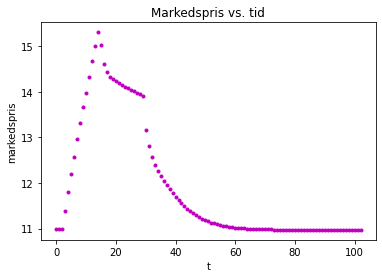

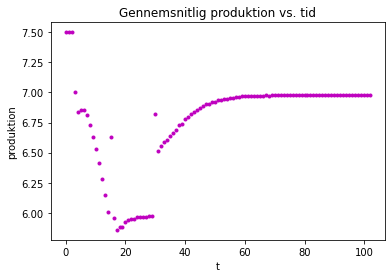

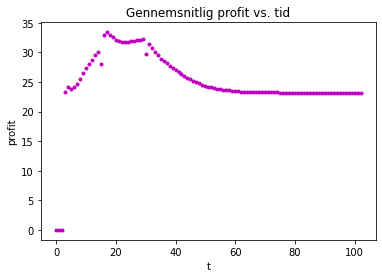

In [8]:
# Markedspris over tid
plt.title('Markedspris vs. tid')
plt.xlabel('t')
plt.ylabel('markedspris')
plt.plot(range(iterations+3), mean_price_list, 'm.')
plt.show()

# Produktion over tid
plt.title('Gennemsnitlig produktion vs. tid')
plt.xlabel('t')
plt.ylabel('produktion')
plt.plot(range(iterations+3), mean_production_list, 'm.')
plt.show()

# Profit over tid
plt.title('Gennemsnitlig profit vs. tid')
plt.xlabel('t')
plt.ylabel('profit')
plt.plot(range(iterations+3), mean_profit_list, 'm.')
plt.show()


## Plot kurver for hver enkelt agent

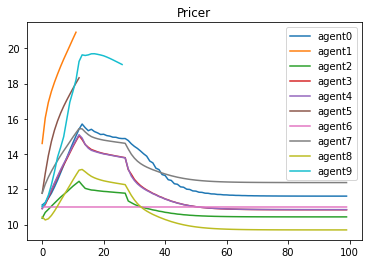

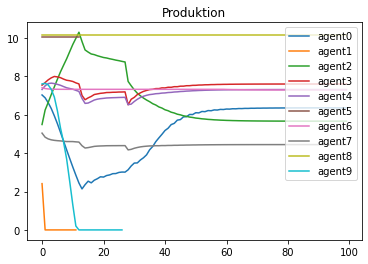

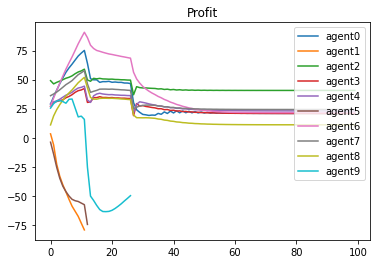

In [9]:
# Visualize how each agent is doing
price_df.plot();
plt.title("Pricer");
plt.legend(loc = "upper right");

quantity_df.plot()
plt.title("Produktion")
plt.legend(loc = "upper right");

profit_df.plot();
plt.title("Profit");
plt.legend(loc = "upper right");